In [5]:
# asume que los datos estan en ../data/<año>.csv.bz2
# fixme: poner el directorio de data que esté en el repo cuando pusheen los pibes

import seaborn as sns
import matplotlib.pyplot as plt

import fnmatch

import pandas as pd
import time
import os
import shutil
#sns.set(color_codes=True)

# load data
tmp_dir = "./tmp_csv/"
years = ["2006", "2007"]

## Procesar datos

In [6]:
#crear directorio con data de delays agrupada por retraso 
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)
    
for year in years:
    if not os.path.exists(tmp_dir+year+".csv"):
        print("Leyendo csv: {}".format(year))
        t = time.time()
        df = pd.read_csv("../data/"+year+".csv.bz2", compression="bz2", usecols=["Month", "Year", "DayofMonth", "DayOfWeek", "DepDelay", "ArrDelay"])    

        #formato mas feliz para fechas
        dates = pd.to_datetime(df.Year*10000+df.Month*100+df.DayofMonth,format='%Y%m%d')
        df["date"] = dates
        df = df[["date", "DepDelay", "ArrDelay"]]

        df = df.groupby(by=df['date'].dt.date).mean()
        df.to_csv(tmp_dir+year+".csv")
        del df 
    

Leyendo csv: 2006
Leyendo csv: 2007


2006.csv


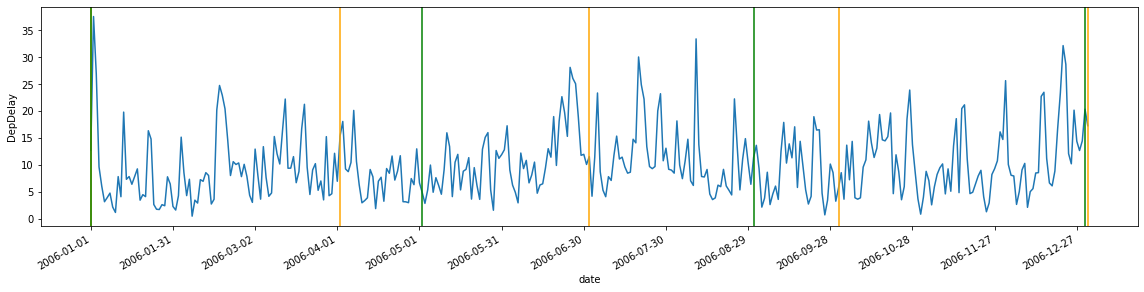

2007.csv


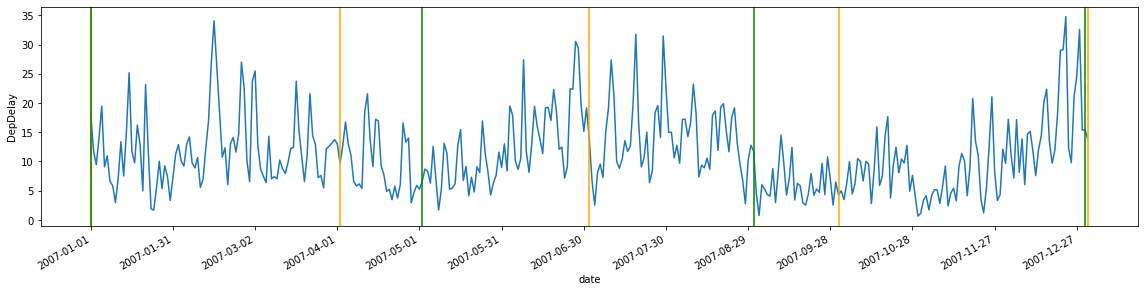

In [7]:
for filename in os.listdir(tmp_dir):
    if filename.endswith(".csv") and filename != "merged.csv": 
        print(filename)
        df = pd.read_csv(tmp_dir+filename)
        fig, ax = plt.subplots(figsize=(16,4))
        sns.lineplot(x=df.date, y=df.DepDelay, linestyle='-')
        plt.xticks(plt.xticks()[0], df.date, rotation=90)
        plt.tight_layout()
        xticks = ax.xaxis.get_major_ticks()
        for i in range(len(xticks)):
            if i%30 != 0:
                xticks[i].set_visible(False)
            if i%int((len(xticks))/4) == 0:    
                plt.axvline(x=i, color="orange")
            if i%int((len(xticks))/3) == 0:    
                plt.axvline(x=i, color="green")
        fig.autofmt_xdate()
        plt.show()
        
#Trimestres en verde, cuatrimestres en naranja

In [8]:
#merge
df = pd.DataFrame(columns=["date", "DepDelay", "ArrDelay"])
for filename in os.listdir(tmp_dir):
    if filename.endswith(".csv") and filename != "merged.csv":
        print(filename)
        df_input = pd.read_csv(tmp_dir+filename)
        df = pd.concat([df, df_input], sort=False)
df.to_csv(tmp_dir+"merged.csv")

2006.csv
2007.csv


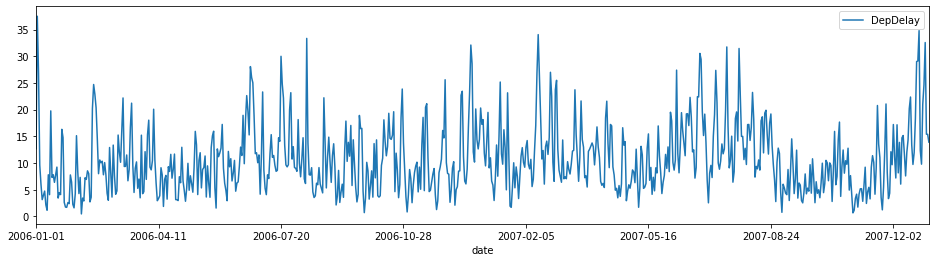

In [9]:
df = pd.read_csv(tmp_dir+"merged.csv")
df.plot(x="date", y="DepDelay", linestyle='-', figsize=(16,4))

## CML acá 

In [60]:
delays = df["DepDelay"]
print(delays)
len(delays)

0      12.690623
1      37.498261
2      26.854514
3       9.605980
4       6.022383
         ...    
725    24.671085
726    32.571997
727    15.394369
728    15.373742
729    13.905018
Name: DepDelay, Length: 730, dtype: float64


730

In [62]:
import numpy as np
import math

n = 5
phases = [i*math.pi/2 for i in range(4)]

# semanas, meses, bimestres, trimestres, cuatrimestres, semestres, años
freqs =  [7] + [355/i for i in [12, 6, 4, 3, 2, 1]]

def trig_vals(t):
    return  [math.sin(2 * math.pi / f * t + p) for f in freqs for p in phases] + \
            [math.cos(2 * math.pi / f * t + p) for f in freqs for p in phases]

A = np.array([])
arrays = []
for i in range(len(delays)):
    row = np.array([i**p for p in range(n+1)] + trig_vals(i))
    arrays.append(row)
    
A = np.stack(arrays)
print(A.shape)

coefs = np.linalg.lstsq(A, delays, rcond=None)[0]

(730, 62)


In [56]:
del df["dl_pred"]
df["dl_pred"] = A@coefs 
df

,Unnamed: 0,date,DepDelay,ArrDelay,dl_pred
0,0,2006-01-01,12.690623,10.206834,0.001018
1,1,2006-01-02,37.498261,39.926864,0.253018
2,2,2006-01-03,26.854514,26.560912,0.500899
3,3,2006-01-04,9.605980,6.143781,0.744835
4,4,2006-01-05,6.022383,3.488482,0.984952
...,...,...,...,...,...
725,360,2007-12-27,24.671085,26.111890,15.874782
726,361,2007-12-28,32.571997,34.465263,16.076504
727,362,2007-12-29,15.394369,13.661200,16.282001
728,363,2007-12-30,15.373742,15.299968,16.491191


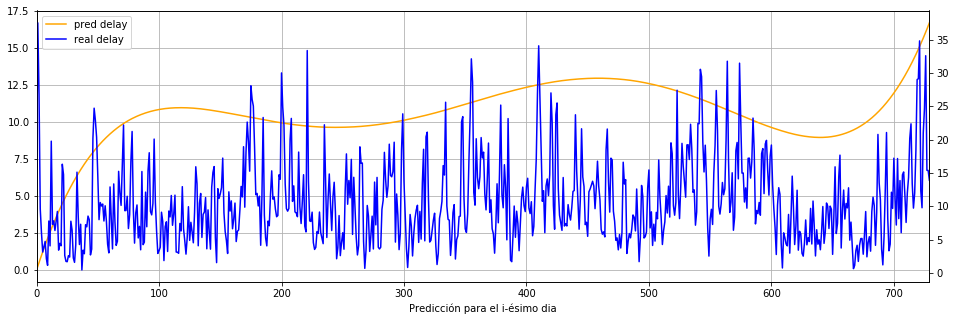

In [41]:
plt.figure(figsize=(16,5))
plt.xlabel('Predicción para el i-ésimo dia')


ax1 = df.dl_pred.plot(color='orange', grid=True, label='pred delay')
ax2 = df.DepDelay.plot(color='blue', grid=True, secondary_y=True, label='real delay')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

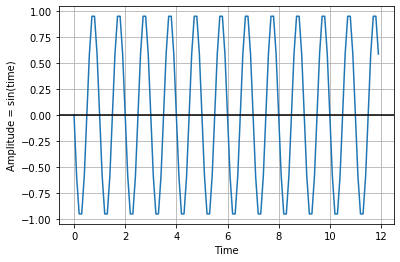

In [101]:
#para jugar con fases
time        = np.arange(0, 12,0.1);
amplitude   = np.sin(2 * math.pi / 1* time + math.pi)
plt.plot(time, amplitude)
plt.show()

## BORRAR ARCHIVOS

In [38]:
#borrar aux de años
for filename in os.listdir(tmp_dir):
    if fnmatch.fnmatch(filename, '*.csv') and filename != "merged.csv":
        os.remove(tmp_dir+filename)

In [4]:
#borrar tmp
shutil.rmtree(tmp_dir)